# Статистические показатели точности распознавания для Tesseract и EasyOCR


Проверка нормальности распределений:
Tesseract CER: W=0.350, p=0.000
Распределение Tesseract CER НЕ нормальное (p ≤ 0.05)
EasyOCR CER: W=0.643, p=0.000
Распределение EasyOCR CER НЕ нормальное (p ≤ 0.05)

Проверка равенства дисперсий:
Тест Левена: F=3.820, p=0.051
Дисперсии равны (гомогенны, p > 0.05)

Распределения не нормальные, используем U-тест Манна-Уитни

Результат U-тест Манна-Уитни: statistic=338998.000, p-value=0.000

Вывод: Обнаружены статистически значимые различия между системами (p ≤ 0.05)


<ipython-input-19-434bdc614bd7>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OCR', y='cer', data=combined_df, palette=palette, width=0.4)


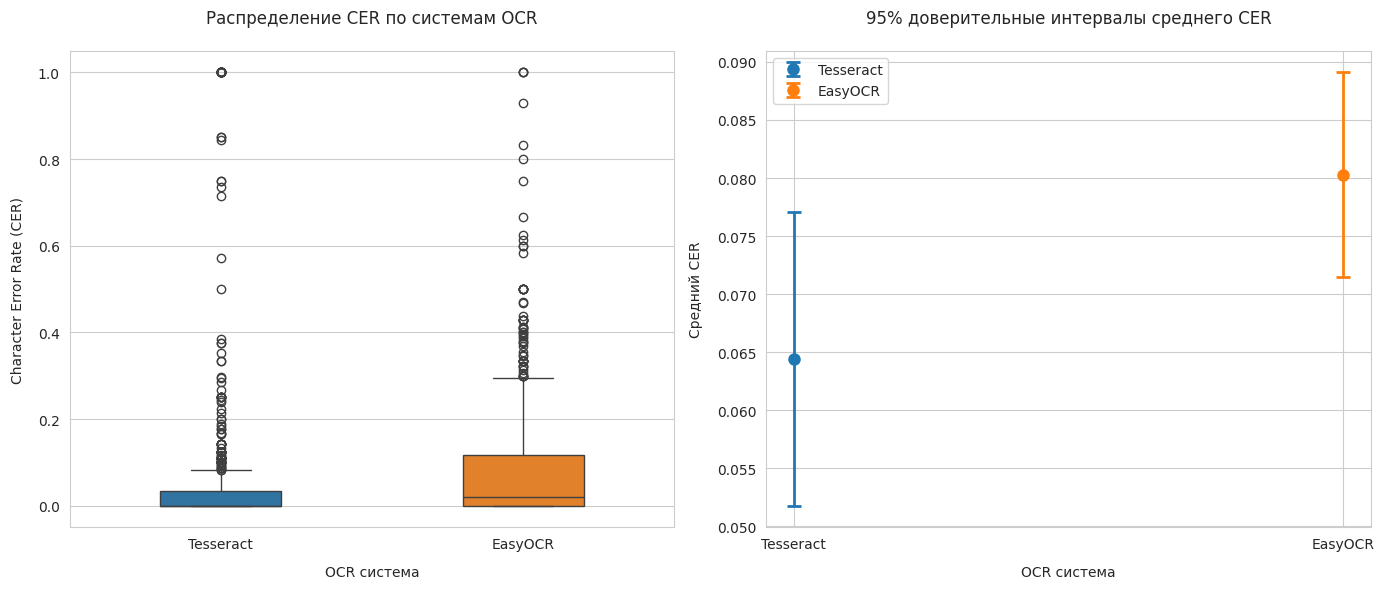


Сравнительный анализ OCR систем:
--------------------------------------------------
Метрика                  Tesseract      EasyOCR        
--------------------------------------------------
mean                     0.0644         0.0803         
std                      0.1942         0.1350         
ci_lower                 0.0518         0.0715         
ci_upper                 0.0771         0.0891         
n                        907.0000       907.0000       

Анализ доверительных интервалов:
Доверительные интервалы перекрываются - разница может быть не значима

Результаты сохранены в: /content/drive/MyDrive/VKR/results/comparison


In [ ]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Пути к данным
TESTSERACT_PATH = '/content/drive/MyDrive/VKR/results/tesseract/tesseract_results.csv'
EASYOCR_PATH = '/content/drive/MyDrive/VKR/results/easyocr/easyocr_results.csv'
OUTPUT_DIR = '/content/drive/MyDrive/VKR/results/comparison'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_data():
    """Загрузка данных из CSV файлов"""
    tesseract_df = pd.read_csv(TESTSERACT_PATH)
    easyocr_df = pd.read_csv(EASYOCR_PATH)
    return tesseract_df, easyocr_df

def preprocess_data(tesseract_df, easyocr_df):
    """Предварительная обработка данных"""
    # Ограничение значений CER от 0 до 1
    tesseract_df['cer'] = tesseract_df['cer'].clip(0, 1)
    easyocr_df['cer'] = easyocr_df['cer'].clip(0, 1)

    # Удаление пропущенных значений
    tesseract_df = tesseract_df.dropna(subset=['cer'])
    easyocr_df = easyocr_df.dropna(subset=['cer'])

    return tesseract_df, easyocr_df

def check_normality_and_variance(tesseract_df, easyocr_df):
    """Проверка нормальности распределения и гомогенности дисперсий"""
    print("\nПроверка нормальности распределений:")

    # Проверка нормальности с помощью теста Шапиро-Уилка
    def normality_test(data, name):
        stat, p = shapiro(data)
        print(f"{name}: W={stat:.3f}, p={p:.3f}")
        if p > 0.05:
            print(f"Распределение {name} нормальное (p > 0.05)")
            return True
        else:
            print(f"Распределение {name} НЕ нормальное (p ≤ 0.05)")
            return False

    t_normal = normality_test(tesseract_df['cer'], "Tesseract CER")
    e_normal = normality_test(easyocr_df['cer'], "EasyOCR CER")

    # Проверка гомогенности дисперсий с помощью теста Левена
    print("\nПроверка равенства дисперсий:")
    stat, p = levene(tesseract_df['cer'], easyocr_df['cer'])
    print(f"Тест Левена: F={stat:.3f}, p={p:.3f}")
    equal_var = p > 0.05
    if equal_var:
        print("Дисперсии равны (гомогенны, p > 0.05)")
    else:
        print("Дисперсии НЕ равны (гетерогенны, p ≤ 0.05)")

    return t_normal, e_normal, equal_var

def perform_statistical_test(tesseract_df, easyocr_df, t_normal, e_normal, equal_var):
    """Выполнение соответствующего статистического теста"""
    if t_normal and e_normal:
        print("\nОба распределения нормальные, используем t-тест")
        stat, p = ttest_ind(tesseract_df['cer'], easyocr_df['cer'], equal_var=equal_var)
        test_name = "t-тест"
    else:
        print("\nРаспределения не нормальные, используем U-тест Манна-Уитни")
        stat, p = mannwhitneyu(tesseract_df['cer'], easyocr_df['cer'])
        test_name = "U-тест Манна-Уитни"

    print(f"\nРезультат {test_name}: statistic={stat:.3f}, p-value={p:.3f}")

    if p > 0.05:
        print("\nВывод: Нет статистически значимых различий между системами (p > 0.05)")
    else:
        print("\nВывод: Обнаружены статистически значимые различия между системами (p ≤ 0.05)")

    return p

def calculate_statistics(tesseract_df, easyocr_df):
    """Расчет статистических показателей и доверительных интервалов"""
    def get_stats(df, name):
        mean = df['cer'].mean()
        std = df['cer'].std()
        n = len(df)
        se = std / np.sqrt(n)
        ci = stats.t.interval(0.95, n-1, loc=mean, scale=se)
        return {
            'OCR': name,
            'mean': mean,
            'std': std,
            'n': n,
            'ci_lower': ci[0],
            'ci_upper': ci[1]
        }

    stats_tesseract = get_stats(tesseract_df, 'Tesseract')
    stats_easyocr = get_stats(easyocr_df, 'EasyOCR')

    return pd.DataFrame([stats_tesseract, stats_easyocr])

def plot_comparison(combined_df, stats_df):
    """Визуализация сравнения OCR систем"""
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    palette = {"Tesseract": "#1f77b4", "EasyOCR": "#ff7f0e"}

    # 1. Boxplot распределений CER
    plt.subplot(1, 2, 1)
    sns.boxplot(x='OCR', y='cer', data=combined_df, palette=palette, width=0.4)
    plt.title('Распределение CER по системам OCR', pad=20)
    plt.ylabel('Character Error Rate (CER)', labelpad=10)
    plt.xlabel('OCR система', labelpad=10)

    # 2. Доверительные интервалы среднего
    plt.subplot(1, 2, 2)
    for _, row in stats_df.iterrows():
        plt.errorbar(x=row['OCR'], y=row['mean'],
                    yerr=[[row['mean'] - row['ci_lower']], [row['ci_upper'] - row['mean']]],
                    fmt='o', capsize=5, capthick=2, elinewidth=2,
                    color=palette[row['OCR']], markersize=8, label=row['OCR'])

    plt.title('95% доверительные интервалы среднего CER', pad=20)
    plt.ylabel('Средний CER', labelpad=10)
    plt.xlabel('OCR система', labelpad=10)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'cer_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

def print_statistical_comparison(stats_df):
    """Вывод статистического сравнения"""
    print("\nСравнительный анализ OCR систем:")
    print("-" * 50)
    print(f"{'Метрика':<25}{'Tesseract':<15}{'EasyOCR':<15}")
    print("-" * 50)

    for metric in ['mean', 'std', 'ci_lower', 'ci_upper', 'n']:
        t_val = stats_df.loc[stats_df['OCR'] == 'Tesseract', metric].values[0]
        e_val = stats_df.loc[stats_df['OCR'] == 'EasyOCR', metric].values[0]
        print(f"{metric:<25}{t_val:<15.4f}{e_val:<15.4f}")

    # Проверка перекрытия интервалов
    t_ci = (stats_df.loc[stats_df['OCR'] == 'Tesseract', 'ci_lower'].values[0],
            stats_df.loc[stats_df['OCR'] == 'Tesseract', 'ci_upper'].values[0])
    e_ci = (stats_df.loc[stats_df['OCR'] == 'EasyOCR', 'ci_lower'].values[0],
            stats_df.loc[stats_df['OCR'] == 'EasyOCR', 'ci_upper'].values[0])

    print("\nАнализ доверительных интервалов:")
    if t_ci[1] < e_ci[0] or e_ci[1] < t_ci[0]:
        print("Доверительные интервалы НЕ перекрываются - разница статистически значима")
    else:
        print("Доверительные интервалы перекрываются - разница может быть не значима")

def main():
    # 1. Загрузка данных
    tesseract_df, easyocr_df = load_data()

    # 2. Предварительная обработка
    tesseract_df, easyocr_df = preprocess_data(tesseract_df, easyocr_df)

    # 3. Проверка нормальности и дисперсий
    t_normal, e_normal, equal_var = check_normality_and_variance(tesseract_df, easyocr_df)

    # 4. Статистический тест
    p_value = perform_statistical_test(tesseract_df, easyocr_df, t_normal, e_normal, equal_var)

    # 5. Подготовка данных для визуализации
    tesseract_vis = tesseract_df[['cer']].assign(OCR='Tesseract')
    easyocr_vis = easyocr_df[['cer']].assign(OCR='EasyOCR')
    combined_df = pd.concat([tesseract_vis, easyocr_vis], ignore_index=True)

    # 6. Расчет статистик
    stats_df = calculate_statistics(tesseract_df, easyocr_df)

    # 7. Визуализация
    plot_comparison(combined_df, stats_df)

    # 8. Вывод результатов
    print_statistical_comparison(stats_df)

    # 9. Сохранение результатов
    stats_df.to_csv(os.path.join(OUTPUT_DIR, 'ocr_stats_comparison.csv'), index=False)
    print(f"\nРезультаты сохранены в: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()

Проверка нормальности распределения CER для обеих библиотек (Tesseract и EasyOCR), включая визуализацию и статистические тесты:

Анализ распределения CER для Tesseract и EasyOCR
Загрузка данных...

Первые 5 строк Tesseract:
                                            image_id          class      time  \
0  kpk_459_page_1_png.rf.766d830189918fa629196a61...   course_topic  0.364532   
1  kpk_459_page_1_png.rf.766d830189918fa629196a61...   organization  0.277490   
2  kpk_459_page_1_png.rf.766d830189918fa629196a61...           name  0.201776   
3  kpk_459_page_1_png.rf.766d830189918fa629196a61...  course_period  0.203038   
4  kpk_459_page_1_png.rf.766d830189918fa629196a61...          hours  0.160224   

        cer  
0  0.012195  
1  0.015873  
2  0.000000  
3  0.000000  
4  0.111111  

Первые 5 строк EasyOCR:
                                            image_id          class      time  \
0  kpk_459_page_1_png.rf.766d830189918fa629196a61...   course_topic  0.600076   
1  kpk_459_page_1_png.rf.766d830189918fa629196a61...   organization  0.794218   
2  kpk_459_page_1_png.rf.766d830189918fa629196a61...           nam

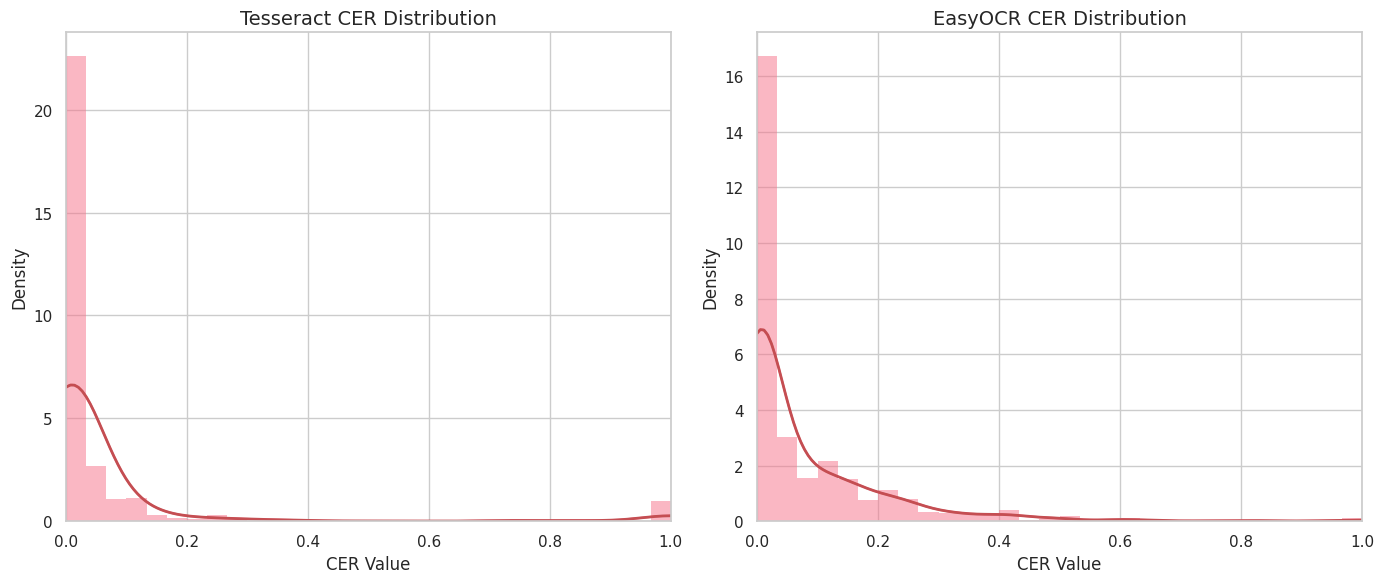

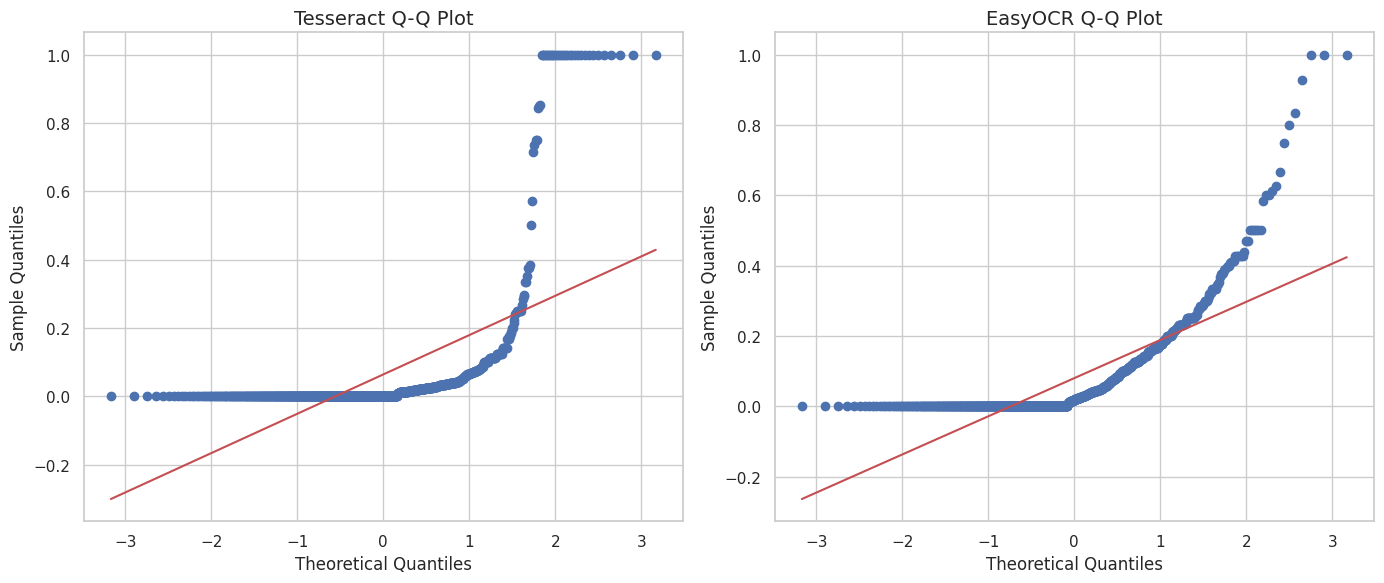


Нормальность распределения CER (статистические тесты)

Tesseract:
Shapiro-Wilk test: W = 0.3497, p-value = 0.0000
Kolmogorov-Smirnov test: D = 0.3700, p-value = 0.0000
Anderson-Darling test: A^2 = 227.6794
Critical values: [0.573 0.653 0.784 0.914 1.087]
Significance levels: [15.  10.   5.   2.5  1. ]

EasyOCR:
Shapiro-Wilk test: W = 0.6434, p-value = 0.0000
Kolmogorov-Smirnov test: D = 0.2759, p-value = 0.0000
Anderson-Darling test: A^2 = 98.8824
Critical values: [0.573 0.653 0.784 0.914 1.087]
Significance levels: [15.  10.   5.   2.5  1. ]

Интерпретация результатов:

Для всех тестов:
H0: Распределение является нормальным
Ha: Распределение не является нормальным

Tesseract (Shapiro-Wilk): Отвергаем H0 (не нормальное) (p = 0.0000)
Tesseract (Kolmogorov-Smirnov): Отвергаем H0 (не нормальное) (p = 0.0000)
EasyOCR (Shapiro-Wilk): Отвергаем H0 (не нормальное) (p = 0.0000)
EasyOCR (Kolmogorov-Smirnov): Отвергаем H0 (не нормальное) (p = 0.0000)

Анализ завершен!


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Пути к данным
TESTSERACT_PATH = '/content/drive/MyDrive/VKR/results/tesseract/tesseract_results.csv'
EASYOCR_PATH = '/content/drive/MyDrive/VKR/results/easyocr/easyocr_results.csv'
OUTPUT_DIR = '/content/drive/MyDrive/VKR/results/comparison'
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_data():
    """Загрузка данных из CSV файлов с проверкой"""
    tesseract_df = pd.read_csv(TESTSERACT_PATH)
    easyocr_df = pd.read_csv(EASYOCR_PATH)

    # Проверка загруженных данных
    print("\nПервые 5 строк Tesseract:")
    print(tesseract_df.head())
    print("\nПервые 5 строк EasyOCR:")
    print(easyocr_df.head())

    return tesseract_df, easyocr_df

def preprocess_data(tesseract_df, easyocr_df):
    """Предварительная обработка данных с тщательной проверкой"""
    # Преобразование в числовой тип и обработка некорректных значений
    tesseract_df['cer'] = pd.to_numeric(tesseract_df['cer'], errors='coerce')
    easyocr_df['cer'] = pd.to_numeric(easyocr_df['cer'], errors='coerce')

    # Проверка данных до обработки
    print("\nСтатистика Tesseract CER до обработки:")
    print(tesseract_df['cer'].describe())
    print("\nЗначения > 1:", sum(tesseract_df['cer'] > 1))
    print("Значения < 0:", sum(tesseract_df['cer'] < 0))
    print("NaN значения:", tesseract_df['cer'].isna().sum())

    print("\nСтатистика EasyOCR CER до обработки:")
    print(easyocr_df['cer'].describe())
    print("\nЗначения > 1:", sum(easyocr_df['cer'] > 1))
    print("Значения < 0:", sum(easyocr_df['cer'] < 0))
    print("NaN значения:", easyocr_df['cer'].isna().sum())

    # Ограничение значений CER от 0 до 1
    tesseract_df['cer'] = tesseract_df['cer'].clip(0, 1)
    easyocr_df['cer'] = easyocr_df['cer'].clip(0, 1)

    # Удаление пропущенных значений
    tesseract_df = tesseract_df.dropna(subset=['cer'])
    easyocr_df = easyocr_df.dropna(subset=['cer'])

    # Проверка данных после обработки
    print("\nСтатистика Tesseract CER после обработки:")
    print(tesseract_df['cer'].describe())
    print("\nСтатистика EasyOCR CER после обработки:")
    print(easyocr_df['cer'].describe())

    return tesseract_df, easyocr_df

def check_normality(tesseract_cer, easyocr_cer):
    """
    Проверка нормальности распределения CER для обеих библиотек
    с использованием визуальных и статистических методов
    """
    # Настройка стиля графиков
    sns.set_theme(style="whitegrid")
    sns.set_palette("husl")

    # 1. Гистограммы с кривыми плотности
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(tesseract_cer, kde=True, stat='density', linewidth=0, bins=30)
    sns.kdeplot(tesseract_cer, color='r', linewidth=2)
    plt.title('Tesseract CER Distribution', fontsize=14)
    plt.xlabel('CER Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(0, 1)  # Явное ограничение оси X

    plt.subplot(1, 2, 2)
    sns.histplot(easyocr_cer, kde=True, stat='density', linewidth=0, bins=30)
    sns.kdeplot(easyocr_cer, color='r', linewidth=2)
    plt.title('EasyOCR CER Distribution', fontsize=14)
    plt.xlabel('CER Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(0, 1)  # Явное ограничение оси X

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'cer_distributions.png'), dpi=300)
    plt.show()

    # 2. Q-Q plots (графики квантиль-квантиль)
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    stats.probplot(tesseract_cer, dist="norm", plot=plt)
    plt.title('Tesseract Q-Q Plot', fontsize=14)
    plt.xlabel('Theoretical Quantiles', fontsize=12)
    plt.ylabel('Sample Quantiles', fontsize=12)

    plt.subplot(1, 2, 2)
    stats.probplot(easyocr_cer, dist="norm", plot=plt)
    plt.title('EasyOCR Q-Q Plot', fontsize=14)
    plt.xlabel('Theoretical Quantiles', fontsize=12)
    plt.ylabel('Sample Quantiles', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'qq_plots.png'), dpi=300)
    plt.show()

    # 3. Статистические тесты на нормальность
    print("\n" + "="*50)
    print("Нормальность распределения CER (статистические тесты)")
    print("="*50 + "\n")

    # Для Tesseract
    print("Tesseract:")
    shapiro_test_t = stats.shapiro(tesseract_cer)
    print(f"Shapiro-Wilk test: W = {shapiro_test_t[0]:.4f}, p-value = {shapiro_test_t[1]:.4f}")

    kstest_t = stats.kstest(tesseract_cer, 'norm', args=(np.mean(tesseract_cer), np.std(tesseract_cer, ddof=1)))
    print(f"Kolmogorov-Smirnov test: D = {kstest_t[0]:.4f}, p-value = {kstest_t[1]:.4f}")

    anderson_t = stats.anderson(tesseract_cer, dist='norm')
    print(f"Anderson-Darling test: A^2 = {anderson_t[0]:.4f}")
    print("Critical values:", anderson_t[1])
    print("Significance levels:", anderson_t[2])

    # Для EasyOCR
    print("\nEasyOCR:")
    shapiro_test_e = stats.shapiro(easyocr_cer)
    print(f"Shapiro-Wilk test: W = {shapiro_test_e[0]:.4f}, p-value = {shapiro_test_e[1]:.4f}")

    kstest_e = stats.kstest(easyocr_cer, 'norm', args=(np.mean(easyocr_cer), np.std(easyocr_cer, ddof=1)))
    print(f"Kolmogorov-Smirnov test: D = {kstest_e[0]:.4f}, p-value = {kstest_e[1]:.4f}")

    anderson_e = stats.anderson(easyocr_cer, dist='norm')
    print(f"Anderson-Darling test: A^2 = {anderson_e[0]:.4f}")
    print("Critical values:", anderson_e[1])
    print("Significance levels:", anderson_e[2])

    # Интерпретация результатов
    print("\n" + "="*50)
    print("Интерпретация результатов:")
    print("="*50 + "\n")

    print("Для всех тестов:")
    print("H0: Распределение является нормальным")
    print("Ha: Распределение не является нормальным\n")

    alpha = 0.05
    for name, p_value in [('Tesseract (Shapiro-Wilk)', shapiro_test_t[1]),
                         ('Tesseract (Kolmogorov-Smirnov)', kstest_t[1]),
                         ('EasyOCR (Shapiro-Wilk)', shapiro_test_e[1]),
                         ('EasyOCR (Kolmogorov-Smirnov)', kstest_e[1])]:
        print(f"{name}: {'Не отвергаем H0 (нормальное)' if p_value > alpha else 'Отвергаем H0 (не нормальное)'} (p = {p_value:.4f})")

def main():
    # Загрузка и предварительная обработка данных
    print("Загрузка данных...")
    tesseract_df, easyocr_df = load_data()

    print("\nПредварительная обработка данных...")
    tesseract_df, easyocr_df = preprocess_data(tesseract_df, easyocr_df)

    # Проверка нормальности распределений
    print("\nПроверка нормальности распределений...")
    check_normality(tesseract_df['cer'], easyocr_df['cer'])

if __name__ == "__main__":
    print("Анализ распределения CER для Tesseract и EasyOCR")
    print("="*60)
    main()
    print("\nАнализ завершен!")

Расчет доверительных интервалов (медианы).
Для ненормальных данных использую бутстреп.

In [23]:
u_stat, p_value = stats.mannwhitneyu(tesseract_cer, easyocr_cer)
print(f"Mann-Whitney U-test: p = {p_value:.4f}")

Mann-Whitney U-test: p = 0.0000


In [24]:
def clt_ci(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)  # Стандартная ошибка среднего
    h = std_err * stats.t.ppf((1 + confidence)/2, n-1)
    return mean - h, mean + h

t_clt_ci = clt_ci(tesseract_cer)
e_clt_ci = clt_ci(easyocr_cer)

In [25]:
t_clt_ci

(np.float64(0.051762438082646925), np.float64(0.07706919607740541))

In [26]:
e_clt_ci

(np.float64(0.07154571403705541), np.float64(0.08920474499307375))

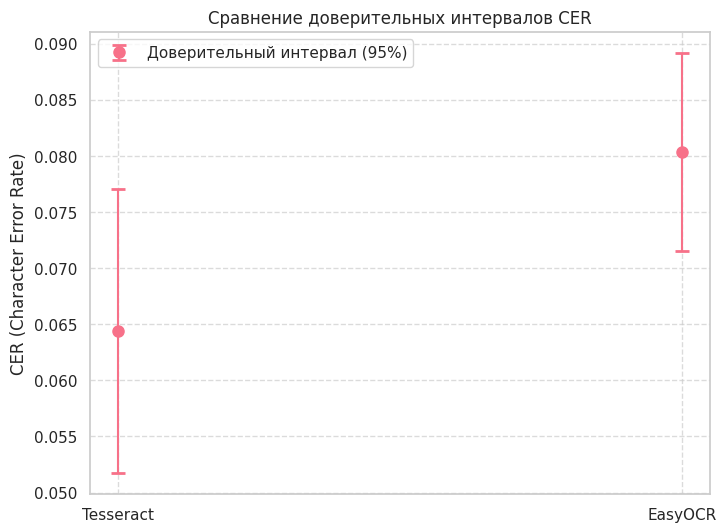

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confidence_intervals(t_clt_ci, e_clt_ci, labels=None):
    """
    Построение диаграммы доверительных интервалов для двух моделей.

    Параметры:
    ----------
    t_clt_ci : tuple
        Доверительный интервал для Tesseract (lower, upper)
    e_clt_ci : tuple
        Доверительный интервал для EasyOCR (lower, upper)
    labels : list, optional
        Подписи для моделей (по умолчанию ['Tesseract', 'EasyOCR'])
    """
    if labels is None:
        labels = ['Tesseract', 'EasyOCR']

    # Средние значения
    t_mean = np.mean(t_clt_ci)
    e_mean = np.mean(e_clt_ci)

    # Ширина доверительных интервалов
    t_err = t_mean - t_clt_ci[0]
    e_err = e_mean - e_clt_ci[0]

    # Создание фигуры
    plt.figure(figsize=(8, 6))

    # Построение точек средних значений
    plt.errorbar(labels, [t_mean, e_mean],
                 yerr=[[t_err, e_err], [t_err, e_err]],
                 fmt='o',
                 capsize=5,
                 capthick=2,
                 markersize=8,
                 label='Доверительный интервал (95%)')

    # Настройки графика
    plt.title('Сравнение доверительных интервалов CER')
    plt.ylabel('CER (Character Error Rate)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.show()

# Пример использования
plot_confidence_intervals(t_clt_ci, e_clt_ci)

In [31]:
def calculate_overlap_percentage(ci1, ci2, method="average"):
    """
    Вычисляет процент пересечения двух доверительных интервалов.

    Параметры:
    ----------
    ci1, ci2 : tuple
        Доверительные интервалы в формате (lower, upper).
    method : str ("average" | "first" | "second")
        Метод вычисления процента:
        - "average" – относительно среднего размера интервалов,
        - "first" – относительно длины первого интервала,
        - "second" – относительно длины второго интервала.

    Возвращает:
    -----------
    overlap_percentage : float
        Процент пересечения (0–100). Если интервалы не пересекаются, возвращает 0.
    """
    l1, u1 = ci1
    l2, u2 = ci2

    overlap = min(u1, u2) - max(l1, l2)

    if overlap <= 0:
        return 0.0  # Нет пересечения

    len1 = u1 - l1
    len2 = u2 - l2

    if method == "average":
        avg_length = (len1 + len2) / 2
        return (overlap / avg_length) * 100
    elif method == "first":
        return (overlap / len1) * 100
    elif method == "second":
        return (overlap / len2) * 100
    else:
        raise ValueError("Метод должен быть 'average', 'first' или 'second'.")

In [33]:
t_clt_ci = (0.0518, 0.0771)  # Дов. интервал Tesseract
e_clt_ci = (0.0715, 0.0892)   # Дов. интервал EasyOCR

overlap_percent = calculate_overlap_percentage(t_clt_ci, e_clt_ci, method="average")
print(f"Пересечение интервалов: {overlap_percent:.1f}%")

Пересечение интервалов: 26.0%


Двухвыборочный t-тест Уэлча (Welch’s t-test):

In [27]:
from scipy import stats

# Предположим, tesseract_cer и easyocr_cer — ваши данные
t_stat, p_value = stats.ttest_ind(tesseract_cer, easyocr_cer, equal_var=False)  # equal_var=False → тест Уэлча
print(f"Welch's t-test: t = {t_stat:.2f}, p = {p_value:.5f}, df ≈ {len(tesseract_cer) + len(easyocr_cer) - 2}")

Welch's t-test: t = -2.03, p = 0.04252, df ≈ 1812


U-тест Манна-Уитни:

In [28]:
u_stat, p_value = stats.mannwhitneyu(tesseract_cer, easyocr_cer, alternative='two-sided')
print(f"Mann-Whitney U-test: U = {u_stat:,.0f}, p = {p_value:.5f}")  # запятая в форматировании для тысяч

Mann-Whitney U-test: U = 338,983, p = 0.00000


Размер эффекта (Cohen’s d):

In [29]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(tesseract_cer, easyocr_cer)
print(f"Cohen's d = {d:.2f}")

Cohen's d = -0.10
